In [28]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import math
from numpy import asarray
from numpy import save
from numpy import load
from keras.models import Sequential
from keras.layers import Dense,Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Input, MaxPooling1D
from sklearn.preprocessing import StandardScaler
import os
import tempfile
import keras
from keras.optimizers import RMSprop
import matplotlib as mpl

In [34]:
EPOCHS = 20
BATCH_SIZE = 16
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load dataset.
dict_train = np.load('noAnno_train_8_nucleotide_array_with_cluster0.npz')
x_train = np.stack(dict_train['arr_0'], axis=0)
y_flt_train = np.load('noAnno_train_8_nucleotide_labels_with_cluster0.npy')
y_train = y_flt_train.astype(int)
print(y_train)


dict_test = np.load('noAnno_test_8_nucleotide_array_with_cluster0.npz')
x_test = np.stack(dict_test['arr_0'], axis=0)
y_flt_test = np.load('noAnno_test_8_nucleotide_labels_with_cluster0.npy')
y_test = y_flt_test.astype(int)
print(y_test)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)
print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
Training features shape: (27570, 8, 4)
Test features shape: (13785, 8, 4)
Training labels shape: (27570,)
Test labels shape: (13785,)


In [35]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [36]:
neg, pos = np.bincount(y_train)+np.bincount(y_test)
total = neg + pos

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)

Examples:
    Total: 41355
    Positive: 2859 (6.91% of total)

Training labels shape: (27570,)
Test labels shape: (13785,)
Training features shape: (27570, 8, 4)
Test features shape: (13785, 8, 4)


In [37]:
def make_model1(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
        # The input shape is 8x4
        # This is the first convolution
        Conv1D(16, 3, strides=1, activation='relu', padding='same',
               input_shape=(8, 4),
               kernel_initializer='he_normal',
               bias_initializer='zeros'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Conv1D(32, 3, strides=1, activation='relu', padding='same',
               kernel_initializer='he_normal',
               bias_initializer='zeros'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Flatten(),
        #  neuron hidden layer
        Dense(128, activation='relu', bias_initializer=output_bias),  # 8/2(maxpooling)=4, 32*4 = 128
        Dropout(0.2),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
        Dense(1, activation='sigmoid')  # Sigmoid for binary question.
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # optimizer=RMSprop(lr=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [38]:
def make_model2(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
        # The input shape is 8x4
        # This is the first convolution
        Conv1D(64, 3, strides=1, activation='relu', padding='same',
               input_shape=(8, 4),
               kernel_initializer='he_normal',
               bias_initializer='zeros'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Conv1D(32, 3, strides=1, activation='relu', padding='same',
               kernel_initializer='he_normal',
               bias_initializer='zeros'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Flatten(),
        #  neuron hidden layer
        Dense(128, activation='relu', bias_initializer=output_bias),  # 8/2(maxpooling)=4, 32*4 = 128
        Dropout(0.2),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
        Dense(1, activation='sigmoid')  # Sigmoid for binary question.
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # optimizer=RMSprop(lr=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [39]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  # plt.semilogy(history.epoch, history.history['val_loss'],
  #              color=colors[n], label='Val ' + label,
  #              linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [40]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-GNRA Detected (True Negatives): ', cm[0][0])
  print('Non-GNRA Incorrectly Detected (False Positives): ', cm[0][1])
  print('GNRA Missed (False Negatives): ', cm[1][0])
  print('GNRA Detected (True Positives): ', cm[1][1])
  print('Total GNRA: ', np.sum(cm[1]))

In [41]:
def plot_metrics(history1, history2):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history1.epoch, history1.history[metric], color=colors[0], label='Conf1_Train')
    plt.plot(history1.epoch, history1.history['val_' + metric],
             color=colors[0], linestyle="--", label='Conf1_Test')
    plt.plot(history2.epoch, history2.history[metric], color=colors[1], label='Conf2_Train')
    plt.plot(history2.epoch, history2.history['val_' + metric],
             color=colors[1], linestyle="--", label='Conf2_Test')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [42]:
def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)  # fpr=false positive rate = fp/(fp+tn), tpr=true positive rate = tp/(tp+fn)

  plt.rcParams['font.size'] = '16'
  plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives rate = fp/(fp+tn)')
  plt.ylabel('True positives rate = tp/(tp+fn)')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [43]:
def plot_prc(name, labels, predictions, **kwargs):  #precision = tp / (tp + fp), recall = tp / (tp + fn)
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.rcParams['font.size'] = '9'
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall = TP / (TP + FP)')
    plt.ylabel('Precision = TP / (TP + FN)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [44]:
# retrain with class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.54
Weight for class 1: 7.23


In [45]:
weighted_model1 = make_model1()
#weighted_model.load_weights(initial_weights)

weighted_history1 = weighted_model1.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight={0: 0.54, 1: 7.23})

Epoch 1/20


2024-01-09 01:48:43.269062: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-09 01:48:43.716856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1724/1724 [==============================] - ETA: 0s - loss: 0.2838 - tp: 1745.0000 - fp: 3069.0000 - tn: 22553.0000 - fn: 203.0000 - accuracy: 0.8813 - precision: 0.3625 - recall: 0.8958 - auc: 0.9534 - prc: 0.7053

2024-01-09 01:49:11.955424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1724/1724 [==============================] - 36s 20ms/step - loss: 0.2838 - tp: 1745.0000 - fp: 3069.0000 - tn: 22553.0000 - fn: 203.0000 - accuracy: 0.8813 - precision: 0.3625 - recall: 0.8958 - auc: 0.9534 - prc: 0.7053 - val_loss: 0.1063 - val_tp: 859.0000 - val_fp: 497.0000 - val_tn: 12377.0000 - val_fn: 52.0000 - val_accuracy: 0.9602 - val_precision: 0.6335 - val_recall: 0.9429 - val_auc: 0.9852 - val_prc: 0.8883
Epoch 2/20
1724/1724 [==============================] - 39s 22ms/step - loss: 0.1724 - tp: 1845.0000 - fp: 1782.0000 - tn: 23840.0000 - fn: 103.0000 - accuracy: 0.9316 - precision: 0.5087 - recall: 0.9471 - auc: 0.9810 - prc: 0.8370 - val_loss: 0.1084 - val_tp: 873.0000 - val_fp: 529.0000 - val_tn: 12345.0000 - val_fn: 38.0000 - val_accuracy: 0.9589 - val_precision: 0.6227 - val_recall: 0.9583 - val_auc: 0.9876 - val_prc: 0.8935
Epoch 3/20
1724/1724 [==============================] - 38s 22ms/step - loss: 0.1527 - tp: 1870.0000 - fp: 1552.0000 - tn: 24070.0000 - fn: 78.00

In [46]:
weighted_model2 = make_model2()
#weighted_model.load_weights(initial_weights)

weighted_history2 = weighted_model2.fit(
    x_train,
    y_train, 
    validation_data = (x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight={0: 0.54, 1: 7.23})

Epoch 1/20


2024-01-09 02:00:57.126992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1724/1724 [==============================] - ETA: 0s - loss: 0.2299 - tp: 2450.0000 - fp: 2881.0000 - tn: 35615.0000 - fn: 409.0000 - accuracy: 0.9204 - precision: 0.4596 - recall: 0.8569 - auc: 0.9184 - prc: 0.6167

2024-01-09 02:01:26.706135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1724/1724 [==============================] - 38s 21ms/step - loss: 0.2299 - tp: 2450.0000 - fp: 2881.0000 - tn: 35615.0000 - fn: 409.0000 - accuracy: 0.9204 - precision: 0.4596 - recall: 0.8569 - auc: 0.9184 - prc: 0.6167 - val_loss: 0.1977 - val_tp: 890.0000 - val_fp: 983.0000 - val_tn: 11891.0000 - val_fn: 21.0000 - val_accuracy: 0.9272 - val_precision: 0.4752 - val_recall: 0.9769 - val_auc: 0.9866 - val_prc: 0.8747
Epoch 2/20
1724/1724 [==============================] - 38s 22ms/step - loss: 0.1498 - tp: 1870.0000 - fp: 1474.0000 - tn: 24148.0000 - fn: 78.0000 - accuracy: 0.9437 - precision: 0.5592 - recall: 0.9600 - auc: 0.9844 - prc: 0.8505 - val_loss: 0.1524 - val_tp: 887.0000 - val_fp: 754.0000 - val_tn: 12120.0000 - val_fn: 24.0000 - val_accuracy: 0.9436 - val_precision: 0.5405 - val_recall: 0.9737 - val_auc: 0.9897 - val_prc: 0.8954
Epoch 3/20
1724/1724 [==============================] - 38s 22ms/step - loss: 0.1318 - tp: 1877.0000 - fp: 1326.0000 - tn: 24296.0000 - fn: 71.000

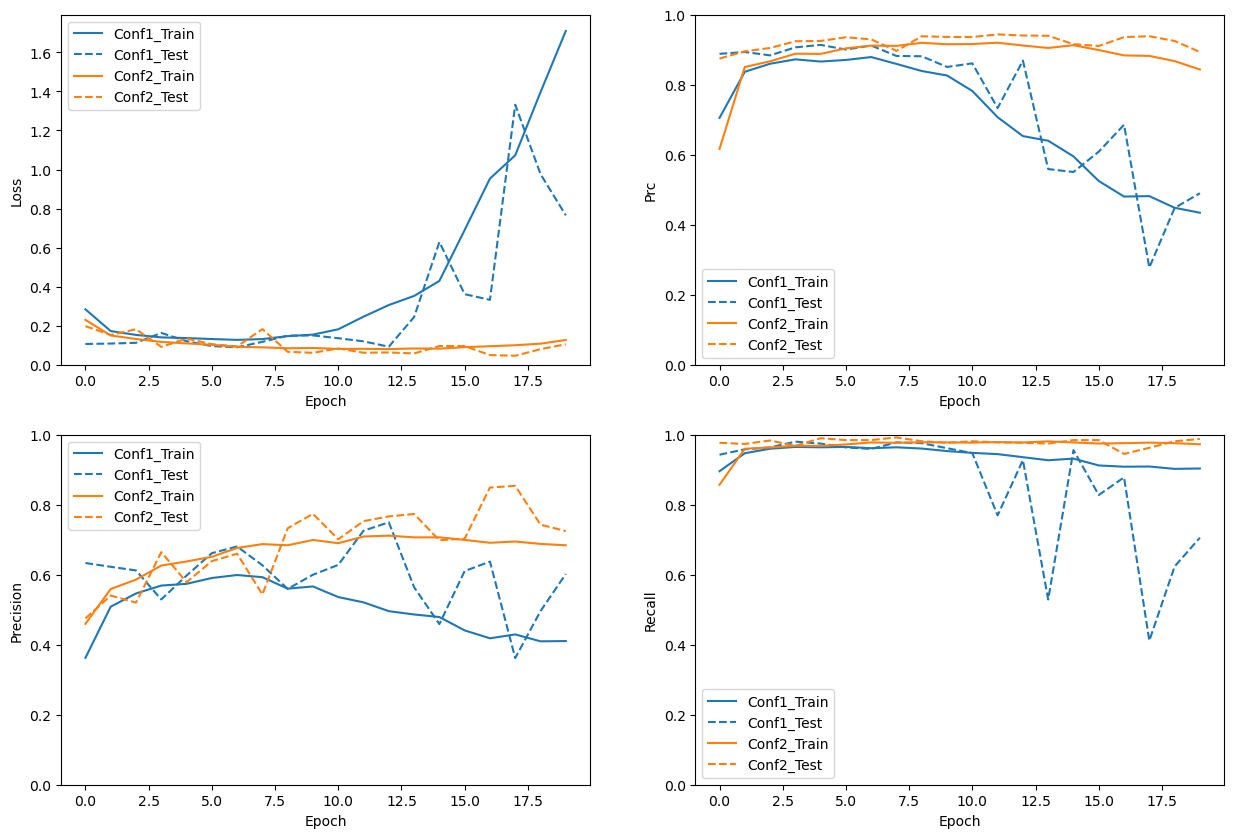

In [47]:
plot_metrics(weighted_history1, weighted_history2)

In [48]:
train_predictions_weighted1 = weighted_model1.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted1 = weighted_model1.predict(x_test, batch_size=BATCH_SIZE)

 105/1724 [>.............................] - ETA: 2s

2024-01-09 02:12:24.046666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


862/862 [==============================] - 1s 2ms/step


In [49]:
train_predictions_weighted2 = weighted_model2.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted2 = weighted_model2.predict(x_test, batch_size=BATCH_SIZE)

 104/1724 [>.............................] - ETA: 2s

2024-01-09 02:12:29.010230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


862/862 [==============================] - 2s 2ms/step


loss :  0.7652451992034912
tp :  643.0
fp :  425.0
tn :  12449.0
fn :  268.0
accuracy :  0.9497280120849609
precision :  0.6020599603652954
recall :  0.7058178186416626
auc :  0.862171471118927
prc :  0.48994261026382446

Non-GNRA Detected (True Negatives):  12449
Non-GNRA Incorrectly Detected (False Positives):  425
GNRA Missed (False Negatives):  268
GNRA Detected (True Positives):  643
Total GNRA:  911


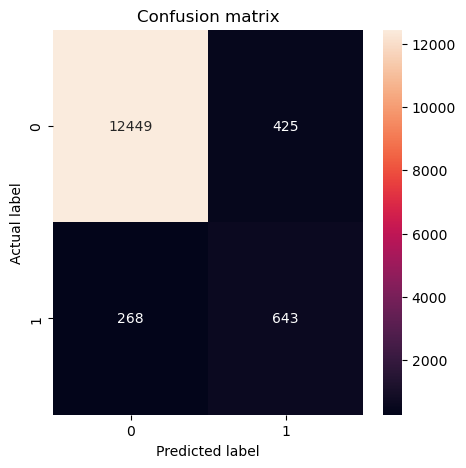

In [50]:
# Results of test data set. 
weighted_results1 = weighted_model1.evaluate(x_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model1.metrics_names, weighted_results1):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted1)

loss :  0.7652451992034912
tp :  643.0
fp :  425.0
tn :  12449.0
fn :  268.0
accuracy :  0.9497280120849609
precision :  0.6020599603652954
recall :  0.7058178186416626
auc :  0.862171471118927
prc :  0.48994261026382446

Non-GNRA Detected (True Negatives):  12532
Non-GNRA Incorrectly Detected (False Positives):  342
GNRA Missed (False Negatives):  11
GNRA Detected (True Positives):  900
Total GNRA:  911


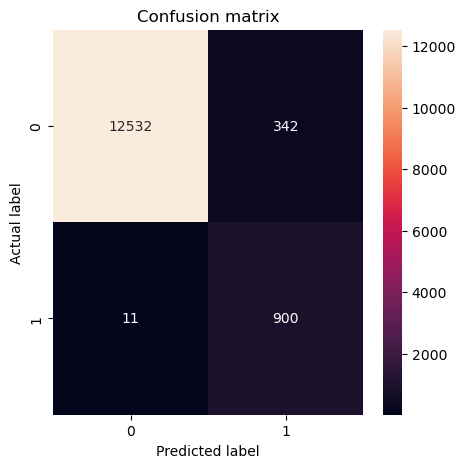

In [51]:
# Results of test data set. 
weighted_results2 = weighted_model2.evaluate(x_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model2.metrics_names, weighted_results1):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted2)

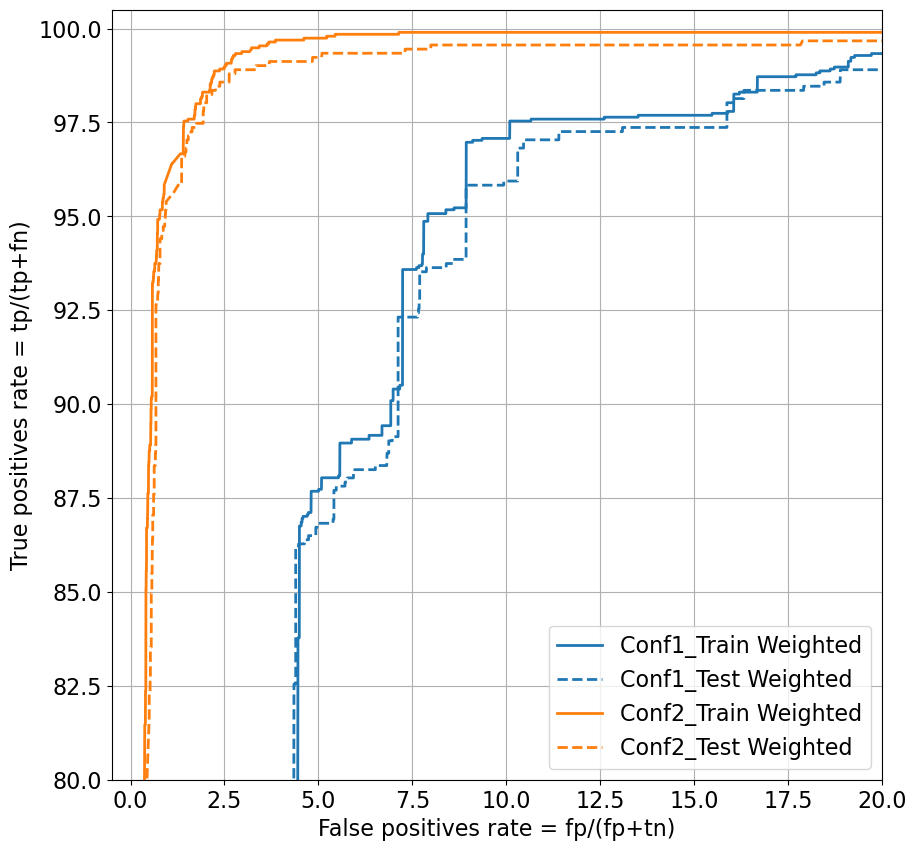

In [52]:
plot_roc("Conf1_Train Weighted", y_train, train_predictions_weighted1, color=colors[0])
plot_roc("Conf1_Test Weighted", y_test, test_predictions_weighted1, color=colors[0], linestyle='--')
plot_roc("Conf2_Train Weighted", y_train, train_predictions_weighted2, color=colors[1])
plot_roc("Conf2_Test Weighted", y_test, test_predictions_weighted2, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

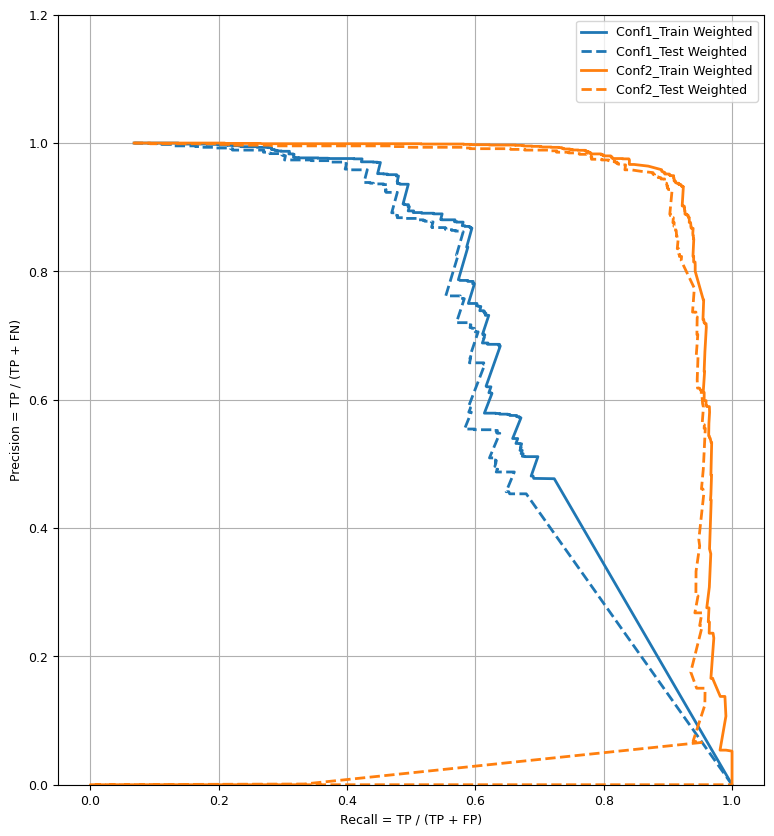

In [53]:
plot_prc("Conf1_Train Weighted", y_train, train_predictions_weighted1, color=colors[0])
plot_prc("Conf1_Test Weighted", y_test, test_predictions_weighted1, color=colors[0], linestyle='--')
plot_prc("Conf2_Train Weighted", y_train, train_predictions_weighted2, color=colors[1])
plot_prc("Conf2_Test Weighted", y_test, test_predictions_weighted2, color=colors[1], linestyle='--')
# plt.xlim([0, 1.2])
plt.ylim([0, 1.2])

plt.legend(loc='upper right');